# Load Datasets from S3 🕸️🕸️

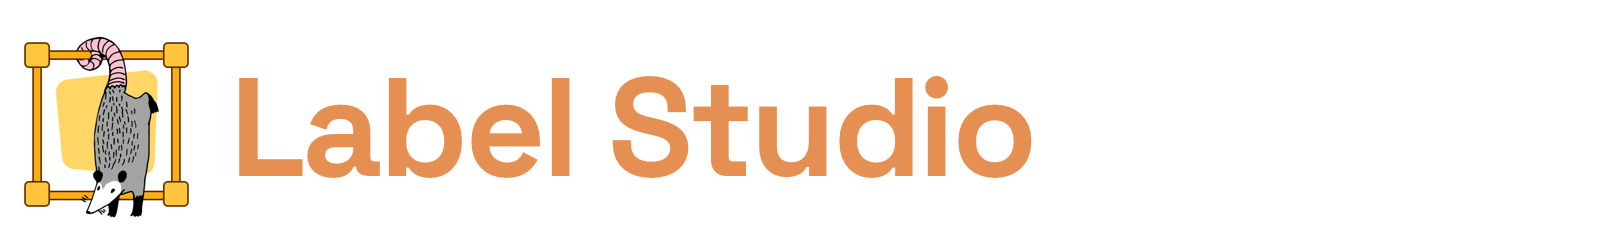

In [8]:
## Imports to load from S3 bucket
import os
import boto3
import ipywidgets as widgets

In [9]:
## S3_ACCESS_KEY_ID & S3_SECRET_ACCESS_KEY should be set as Env variables
key_id = os.environ.get('AWS_ACCESS_KEY_ID')
secret_key = os.environ.get('AWS_SECRET_ACCESS_KEY')
bucket_name= "showcases"
endpoint_s3 = os.environ.get("AWS_S3_ENDPOINT")

## Load the bucket and file path 
#bucket_name = os.environ.get("AWS_S3_BUCKET")
if(key_id is None or secret_key is None or bucket_name is None):
    raise TypeError("An env variables is not set")

In [10]:
dataset_name = "intents-copa"
full_path = f"{bucket_name}/datasets/labeled/text-classification/{dataset_name}"

In [11]:
print(f"\n Getting from S3 bucket: {bucket_name}")
print(f"\nIn path: {full_path}")
session = boto3.session.Session()
s3_client = session.client('s3',
                        region_name='nyc3',
                        endpoint_url=endpoint_s3,
                        aws_access_key_id=key_id,
                        aws_secret_access_key=secret_key)


 Getting from S3 bucket: showcases

In path: showcases/datasets/labeled/text-classification/intents-copa


In [12]:
paginator=s3_client.get_paginator('list_objects_v2')
pages=paginator.paginate(Bucket=bucket_name,Prefix=f"datasets/labeled/text-classification/{dataset_name}")

In [13]:
import json
from tqdm.notebook import trange, tqdm

rows=[]
id2label={}
label2id={}

i = 0
j = 0
for page in pages:
    # Since we also don't know the total number of objects, wrap this loop with tqdm as well
    # Set leave=False to clear each object's progress bar upon completion, reducing clutter
    for obj in tqdm(page['Contents'], leave=False, desc='Loading annotations'):
        data = s3_client.get_object(Bucket=bucket_name, Key=obj.get('Key'))
        content = (data['Body'].read()).decode("utf-8")
        if(i > 0 and isinstance(content, str)):
            annotation = json.loads(content)
            result = annotation.get("result")
            if(len(result) <= 0):
                continue
            label = ((result[0]).get("value")).get("choices")[0]

            if(label not in label2id):
                label2id[label] = j
                id2label[j] = label
                j += 1
            row = {
                (annotation.get("result")[0]).get("from_name"): label,
                **(annotation.get("task")).get("data"),
            }
            rows.append(row)
        i += 1

Loading annotations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading annotations:   0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
import pandas
df= pandas.DataFrame(rows)
df.to_csv(path_or_buf='./dataset.csv',index=False)
print(f"\nDataframe creation completed")
print(f"A total amount of {i} rows were processed")
print(f"Resulting label2id:\n{label2id}")

with open('label2id.json', 'w') as fp:
    json.dump(label2id, fp)
with open('id2label.json', 'w') as fp:
    json.dump(id2label, fp)


Dataframe creation completed
A total amount of 2000 rows were processed
Resulting label2id:
{'spam': 0, 'conversational': 1, 'irrelevant': 2}


---